In [134]:
import datetime
import numpy as np
from client import MarlinServiceClient
from marlin_service_pb2 import DataType
import pandas as pd
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from data_prep import stratified_sample
from data_prep import go_lgbm
from data_prep import extract_feature_list
import lightgbm as lgb
import feather
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
import s3fs
import fsspec

### Import Data & Background

Direct marketing, either through mail, email, phone, etc., is a common tactic to acquire customers. Because resources and a customer's attention is limited, the goal is to only target the subset of prospects who are likely to engage with a specific offer. Predicting those potential customers based on readily available information like demographics, past interactions, and environmental factors is a common machine learning problem.

This notebook presents an example problem to predict if a customer will enroll for a term deposit at a bank, after one or more phone calls.

In [135]:
data = pd.read_feather('data/dataset_target.feather') # Read data from stored feather file

### Background on the Features:

**Demographics:**

age: Customer's age (numeric)  
job: Type of job (categorical: 'admin.', 'services', ...)  
marital: Marital status (categorical: 'married', 'single', ...)  
education: Level of education (categorical: 'basic.4y', 'high.school', ...)  

**Past customer events:**

default: Has credit in default? (categorical: 'no', 'unknown', ...)  
housing: Has housing loan? (categorical: 'no', 'yes', ...)  
loan: Has personal loan? (categorical: 'no', 'yes', ...)  

**Past direct marketing contacts:**

contact: Contact communication type (categorical: 'cellular', 'telephone', ...)  
month: Last contact month of year (categorical: 'may', 'nov', ...)  
day_of_week: Last contact day of the week (categorical: 'mon', 'fri', ...)  
duration: Last contact duration, in seconds (numeric). Important note: If duration = 0 then y = 'no'.  

**Campaign information:**

campaign: Number of contacts performed during this campaign and for this client (numeric, includes last contact)  
pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric)  
previous: Number of contacts performed before this campaign and for this client (numeric)  
poutcome: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)  

**External environment factors:**

emp.var.rate: Employment variation rate - quarterly indicator (numeric)  
cons.price.idx: Consumer price index - monthly indicator (numeric)  
cons.conf.idx: Consumer confidence index - monthly indicator (numeric)  
euribor3m: Euribor 3 month rate - daily indicator (numeric)  
nr.employed: Number of employees - quarterly indicator (numeric)  

**Target variable:**

y: Has the client subscribed a term deposit? (binary: 'yes','no')  

In [136]:
# SERVER_ADDRESS = 'adf0a1d0751e2408f90c70b57f632f40-2005567722.us-west-2.elb.amazonaws.com'
# PORT = 7060

SERVER_ADDRESS = '0.0.0.0'
PORT = 6060
LOCATION_BATCH_FEATURES = "/tmp/flink-job"

client = MarlinServiceClient(SERVER_ADDRESS, PORT, LOCATION_BATCH_FEATURES)

In [137]:
data

,cust_id,campaign_id,default,housing,loan,contact,month,day_of_week,duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,target_timestamp
0,100,1010,no,no,no,telephone,may,mon,261,1.1,93.994,-36.4,4.857,5191.0,no,1588291200
1,101,1011,unknown,no,no,telephone,may,mon,149,1.1,93.994,-36.4,4.857,5191.0,no,1588291200
2,102,1012,no,yes,no,telephone,may,mon,226,1.1,93.994,-36.4,4.857,5191.0,no,1588291200
3,103,1013,no,no,no,telephone,may,mon,151,1.1,93.994,-36.4,4.857,5191.0,no,1588291200
4,104,1014,no,no,yes,telephone,may,mon,307,1.1,93.994,-36.4,4.857,5191.0,no,1588291200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,41283,42193,no,yes,no,cellular,nov,fri,334,-1.1,94.767,-50.8,1.028,4963.6,yes,1588291200
41184,41284,42194,no,no,no,cellular,nov,fri,383,-1.1,94.767,-50.8,1.028,4963.6,no,1588291200
41185,41285,42195,no,yes,no,cellular,nov,fri,189,-1.1,94.767,-50.8,1.028,4963.6,no,1588291200
41186,41286,42196,no,no,no,cellular,nov,fri,442,-1.1,94.767,-50.8,1.028,4963.6,yes,1588291200


In [138]:
%%time
fsspec.filesystem('s3').invalidate_cache()
all_features=['campaign_info:campaign', 'campaign_info:pdays', 'campaign_info:previous', 'campaign_info:poutcome', 
              'demographics:age', 'demographics:job', 'demographics:marital', 'demographics:education']
result = client.get_batch_features(data, all_features)
result.to_feather('data/store_batch_features.feather')

CPU times: user 1min 9s, sys: 849 ms, total: 1min 10s
Wall time: 1min 9s


In [139]:
data = pd.read_feather('data/store_batch_features.feather')
result = pd.read_feather('data/store_batch_features.feather')

In [140]:
result.shape

(41188, 24)

In [141]:
result.count()

cust_id                   41188
campaign_id               41188
default                   41188
housing                   41188
loan                      41188
                          ...  
campaign_info.poutcome    41188
demographics.age          41188
demographics.job          41188
demographics.marital      41188
demographics.education    41188
Length: 24, dtype: int64

In [142]:
result.head(5)

,cust_id,campaign_id,default,housing,loan,contact,month,day_of_week,duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,target_timestamp,campaign_info.campaign,campaign_info.pdays,campaign_info.previous,campaign_info.poutcome,demographics.age,demographics.job,demographics.marital,demographics.education
0,100,1010,no,no,no,telephone,may,mon,261,1.1,93.994,-36.4,4.857,5191.0,no,1588291200,1,999,0,nonexistent,56,housemaid,married,basic.4y
1,101,1011,unknown,no,no,telephone,may,mon,149,1.1,93.994,-36.4,4.857,5191.0,no,1588291200,1,999,0,nonexistent,57,services,married,high.school
2,102,1012,no,yes,no,telephone,may,mon,226,1.1,93.994,-36.4,4.857,5191.0,no,1588291200,1,999,0,nonexistent,37,services,married,high.school
3,103,1013,no,no,no,telephone,may,mon,151,1.1,93.994,-36.4,4.857,5191.0,no,1588291200,1,999,0,nonexistent,40,admin.,married,basic.6y
4,104,1014,no,no,yes,telephone,may,mon,307,1.1,93.994,-36.4,4.857,5191.0,no,1588291200,1,999,0,nonexistent,56,services,married,high.school


In [143]:
result.tail(5)

,cust_id,campaign_id,default,housing,loan,contact,month,day_of_week,duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,target_timestamp,campaign_info.campaign,campaign_info.pdays,campaign_info.previous,campaign_info.poutcome,demographics.age,demographics.job,demographics.marital,demographics.education
41183,41283,42193,no,yes,no,cellular,nov,fri,334,-1.1,94.767,-50.8,1.028,4963.6,yes,1588291200,1,999,0,nonexistent,73,retired,married,professional.course
41184,41284,42194,no,no,no,cellular,nov,fri,383,-1.1,94.767,-50.8,1.028,4963.6,no,1588291200,1,999,0,nonexistent,46,blue-collar,married,professional.course
41185,41285,42195,no,yes,no,cellular,nov,fri,189,-1.1,94.767,-50.8,1.028,4963.6,no,1588291200,2,999,0,nonexistent,56,retired,married,university.degree
41186,41286,42196,no,no,no,cellular,nov,fri,442,-1.1,94.767,-50.8,1.028,4963.6,yes,1588291200,1,999,0,nonexistent,44,technician,married,professional.course
41187,41287,42197,no,yes,no,cellular,nov,fri,239,-1.1,94.767,-50.8,1.028,4963.6,no,1588291200,3,999,1,failure,74,retired,married,professional.course


### Data Exploration

col_0,% observations
default,
no,0.791201
unknown,0.208726
yes,0.000073


col_0,% observations
housing,
no,0.452122
unknown,0.024036
yes,0.523842


col_0,% observations
loan,
no,0.824269
unknown,0.024036
yes,0.151695


col_0,% observations
contact,
cellular,0.634748
telephone,0.365252


col_0,% observations
month,
apr,0.063902
aug,0.149995
dec,0.004419
jul,0.174177
jun,0.129115
mar,0.013256
may,0.334296
nov,0.099568
oct,0.017432


col_0,% observations
day_of_week,
fri,0.190031
mon,0.206711
thu,0.209357
tue,0.196416
wed,0.197485


col_0,% observations
y,
no,0.887346
yes,0.112654


col_0,% observations
campaign_info.poutcome,
failure,0.103234
nonexistent,0.863431
success,0.033335


col_0,% observations
demographics.job,
admin.,0.253035
blue-collar,0.224677
entrepreneur,0.035350
housemaid,0.025736
management,0.070992
retired,0.041760
self-employed,0.034500
services,0.096363
student,0.021244


col_0,% observations
demographics.marital,
divorced,0.111974
married,0.605225
single,0.280859
unknown,0.001942


col_0,% observations
demographics.education,
basic.4y,0.101389
basic.6y,0.055647
basic.9y,0.146766
high.school,0.231014
illiterate,0.000437
professional.course,0.127294
university.degree,0.295426
unknown,0.042027


,cust_id,campaign_id,duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target_timestamp,campaign_info.campaign,campaign_info.pdays,campaign_info.previous,demographics.age
count,41188.00000,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,4.118800e+04,41188.000000,41188.000000,41188.000000,41188.00000
mean,20693.50000,21603.50000,258.285010,0.081886,93.575664,-40.502600,3.621291,5167.035911,1.588291e+09,2.567593,962.475454,0.172963,40.02406
std,11890.09578,11890.09578,259.279249,1.570960,0.578840,4.628198,1.734447,72.251528,0.000000e+00,2.770014,186.910907,0.494901,10.42125
min,100.00000,1010.00000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,1.588291e+09,1.000000,0.000000,0.000000,17.00000
25%,10396.75000,11306.75000,102.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,1.588291e+09,1.000000,999.000000,0.000000,32.00000
50%,20693.50000,21603.50000,180.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,1.588291e+09,2.000000,999.000000,0.000000,38.00000
75%,30990.25000,31900.25000,319.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,1.588291e+09,3.000000,999.000000,0.000000,47.00000
max,41287.00000,42197.00000,4918.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.588291e+09,56.000000,999.000000,7.000000,98.00000


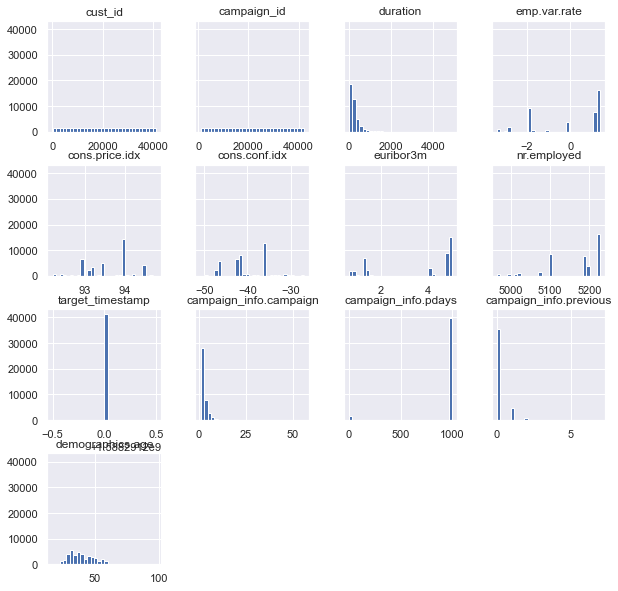

In [144]:
# Frequency tables for each categorical feature
for column in result.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=result[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(result.describe())
%matplotlib inline
hist = result.hist(bins=30, sharey=True, figsize=(10, 10))

In [145]:
# sns.pairplot(data, hue='y', height=3.5);

y,no,yes
default,,
no,0.776814,0.904526
unknown,0.223104,0.095474
yes,0.000082,0.000000


y,no,yes
housing,,
no,0.454088,0.436638
unknown,0.024160,0.023060
yes,0.521752,0.540302


y,no,yes
loan,,
no,0.823574,0.829741
unknown,0.024160,0.023060
yes,0.152266,0.147198


y,no,yes
contact,,
cellular,0.60991,0.830388
telephone,0.39009,0.169612


y,no,yes
month,,
apr,0.057267,0.116164
aug,0.151116,0.141164
dec,0.002545,0.019181
jul,0.178532,0.139871
jun,0.130212,0.120474
mar,0.007388,0.059483
may,0.352495,0.190948
nov,0.100826,0.089655
oct,0.011027,0.067888


y,no,yes
day_of_week,,
fri,0.191009,0.182328
mon,0.209779,0.182543
thu,0.207344,0.225216
tue,0.195277,0.205388
wed,0.196591,0.204526


y,no,yes
campaign_info.poutcome,,
failure,0.099787,0.130388
nonexistent,0.887107,0.676940
success,0.013106,0.192672


y,no,yes
demographics.job,,
admin.,0.248167,0.291379
blue-collar,0.235745,0.137500
entrepreneur,0.036445,0.026724
housemaid,0.026103,0.022845
management,0.071030,0.070690
retired,0.035187,0.093534
self-employed,0.034804,0.032112
services,0.099759,0.069612
student,0.016417,0.059267


y,no,yes
demographics.marital,,
divorced,0.113166,0.102586
married,0.612783,0.545690
single,0.272190,0.349138
unknown,0.001861,0.002586


y,no,yes
demographics.education,,
basic.4y,0.102550,0.092241
basic.6y,0.057568,0.040517
basic.9y,0.152457,0.101940
high.school,0.232133,0.222198
illiterate,0.000383,0.000862
professional.course,0.127175,0.128233
university.degree,0.287239,0.359914
unknown,0.040495,0.054095


cust_id


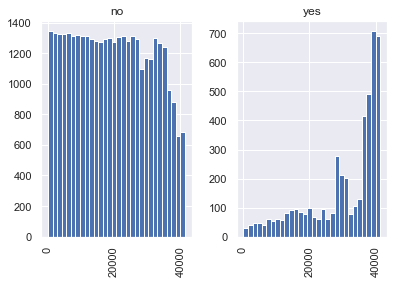

campaign_id


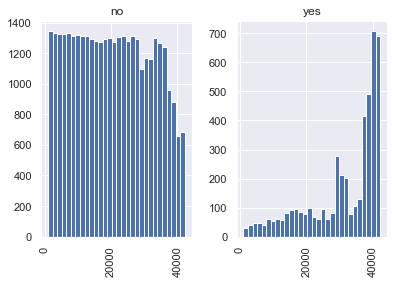

duration


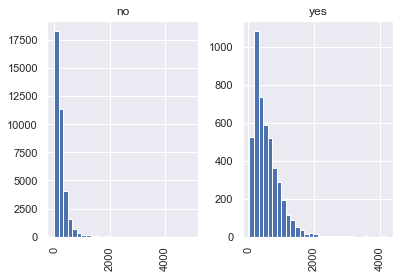

emp.var.rate


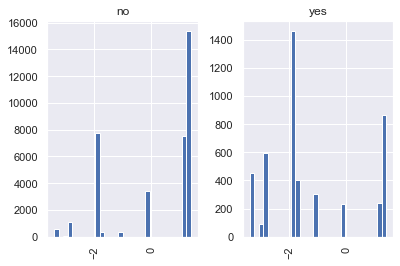

cons.price.idx


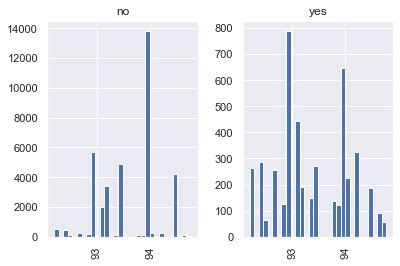

cons.conf.idx


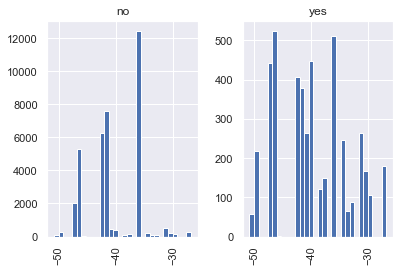

euribor3m


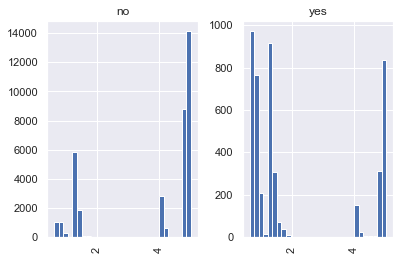

nr.employed


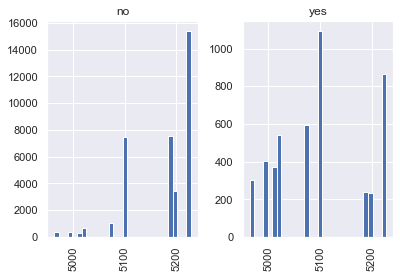

target_timestamp


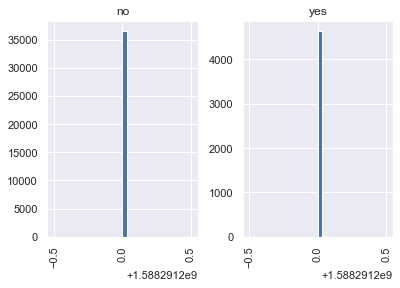

campaign_info.campaign


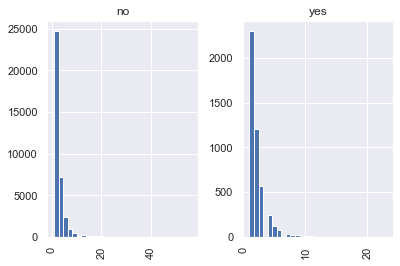

campaign_info.pdays


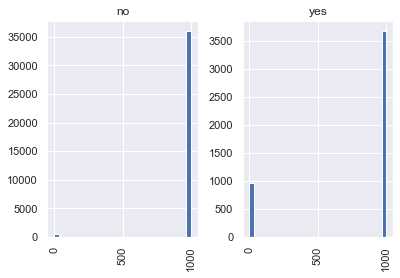

campaign_info.previous


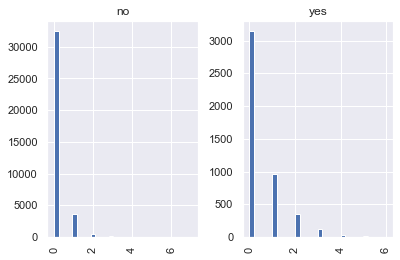

demographics.age


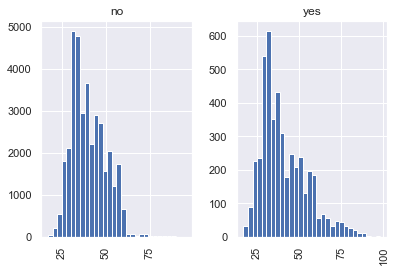

In [146]:
for column in result.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=result[column], columns=result['y'], normalize='columns'))

for column in result.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = result[[column, 'y']].hist(by='y', bins=30)
    plt.show()

,cust_id,campaign_id,duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target_timestamp,campaign_info.campaign,campaign_info.pdays,campaign_info.previous,demographics.age
cust_id,1.000000,1.000000,0.008529,-0.834661,-0.737559,-0.257615,-0.850484,-0.758164,NaN,-0.093589,-0.283919,0.427815,0.003910
campaign_id,1.000000,1.000000,0.008529,-0.834661,-0.737559,-0.257615,-0.850484,-0.758164,NaN,-0.093589,-0.283919,0.427815,0.003910
duration,0.008529,0.008529,1.000000,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,NaN,-0.071699,-0.047577,0.020640,-0.000866
emp.var.rate,-0.834661,-0.834661,-0.027968,1.000000,0.775334,0.196041,0.972245,0.906970,NaN,0.150754,0.271004,-0.420489,-0.000371
cons.price.idx,-0.737559,-0.737559,0.005312,0.775334,1.000000,0.058986,0.688230,0.522034,NaN,0.127836,0.078889,-0.203130,0.000857
cons.conf.idx,-0.257615,-0.257615,-0.008173,0.196041,0.058986,1.000000,0.277686,0.100513,NaN,-0.013733,-0.091342,-0.050936,0.129372
euribor3m,-0.850484,-0.850484,-0.032897,0.972245,0.688230,0.277686,1.000000,0.945154,NaN,0.135133,0.296899,-0.454494,0.010767
nr.employed,-0.758164,-0.758164,-0.044703,0.906970,0.522034,0.100513,0.945154,1.000000,NaN,0.144095,0.372605,-0.501333,-0.017725
target_timestamp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign_info.campaign,-0.093589,-0.093589,-0.071699,0.150754,0.127836,-0.013733,0.135133,0.144095,NaN,1.000000,0.052584,-0.079141,0.004594


/Users/nadeem/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 1588291200.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/nadeem/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 1588291200.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/nadeem/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 1588291200.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


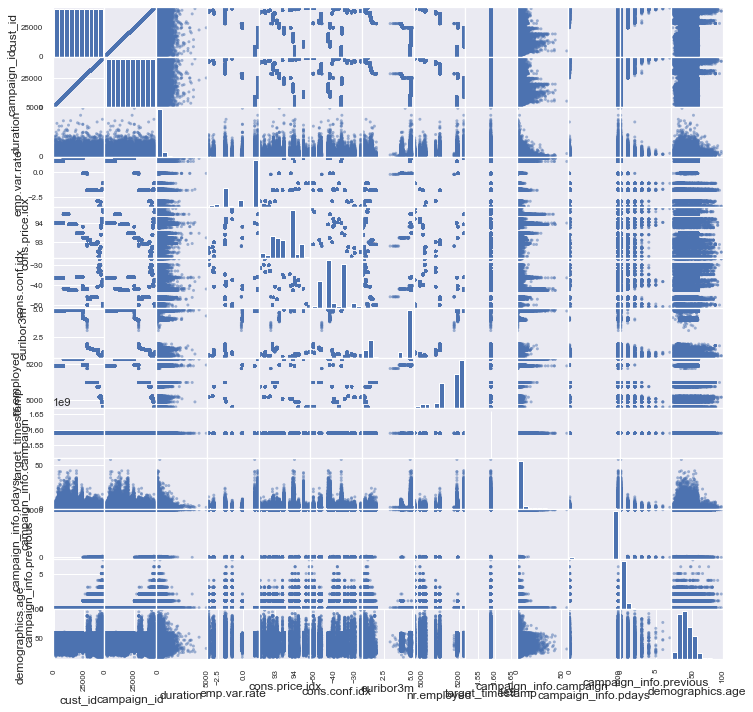

In [147]:
display(result.corr())
pd.plotting.scatter_matrix(result, figsize=(12, 12))
plt.show()

### Data Prep and Transformations

In [148]:
result['no_previous_contact'] = np.where(result['campaign_info.pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
result['not_working'] = np.where(np.in1d(result['demographics.job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed
model_dataset = pd.get_dummies(result)                                                                  # Convert categorical variables to sets of indicators

In [149]:
model_dataset = model_dataset.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed','target_timestamp'], axis=1)

In [150]:
# Randomly split out data --> first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(model_dataset.sample(frac=1, random_state=1729), [int(0.7 * len(model_dataset)), int(0.9 * len(model_dataset))])

In [151]:
train_data

,cust_id,campaign_id,campaign_info.campaign,campaign_info.pdays,campaign_info.previous,demographics.age,no_previous_contact,not_working,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,y_no,y_yes,campaign_info.poutcome_failure,campaign_info.poutcome_nonexistent,campaign_info.poutcome_success,demographics.job_admin.,demographics.job_blue-collar,demographics.job_entrepreneur,demographics.job_housemaid,demographics.job_management,demographics.job_retired,demographics.job_self-employed,demographics.job_services,demographics.job_student,demographics.job_technician,demographics.job_unemployed,demographics.job_unknown,demographics.marital_divorced,demographics.marital_married,demographics.marital_single,demographics.marital_unknown,demographics.education_basic.4y,demographics.education_basic.6y,demographics.education_basic.9y,demographics.education_high.school,demographics.education_illiterate,demographics.education_professional.course,demographics.education_university.degree,demographics.education_unknown
40949,41049,41959,3,999,0,54,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
9332,9432,10342,2,999,0,56,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
32286,32386,33296,2,999,0,32,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3925,4025,4935,3,999,0,46,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
9406,9506,10416,2,999,0,35,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,3971,4881,2,999,0,32,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
16681,16781,17691,2,999,0,26,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
39272,39372,40282,1,6,2,33,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
7717,7817,8727,4,999,0,32,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [152]:
train_data_X = train_data.drop(['y_no', 'y_yes','cust_id','campaign_id'], axis=1)
test_data_X= test_data.drop(['y_no', 'y_yes','cust_id','campaign_id'], axis=1)

In [153]:
train_data_y = train_data[['y_yes']]
test_data_y = test_data[['y_yes']]

### Model Training and Selection
*Light GBM is a gradient boosting framework that uses tree based learning algorithm. It grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. Leaf-wise algorithm can reduce more loss than a level-wise algorithm.*  
  
**We will train the model over a range of hyper-parameters and find the model with the highest accuracy**


In [155]:
pred_test, model, evals_result = go_lgbm(train_data_X, train_data_y, test_data_X, test_data_y, test_data)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.767253
[100]	valid_0's auc: 0.768367
[150]	valid_0's auc: 0.770337
[200]	valid_0's auc: 0.772162
[250]	valid_0's auc: 0.772895
[300]	valid_0's auc: 0.773361
[350]	valid_0's auc: 0.773458
Early stopping, best iteration is:
[322]	valid_0's auc: 0.773592


In [159]:
# Extract feature importances 
feature_importance_values = model.feature_importance()
# List of feature names
features = list(test_data_X.columns)
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
feature_importances.sort_values(by='importance', ascending=False).head(n=14)

,feature,importance
3,demographics.age,8010
0,campaign_info.campaign,2166
2,campaign_info.previous,510
23,month_may,465
17,month_apr,401
18,month_aug,393
35,demographics.job_admin.,380
57,demographics.education_university.degree,375
28,day_of_week_mon,367
24,month_nov,357


### Feature Pipeline, Ingestion and Online Feature Serving 

In [160]:
feature_data=validation_data.drop(['y_no', 'y_yes'], axis=1)
feature_data

,cust_id,campaign_id,campaign_info.campaign,campaign_info.pdays,campaign_info.previous,demographics.age,no_previous_contact,not_working,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,campaign_info.poutcome_failure,campaign_info.poutcome_nonexistent,campaign_info.poutcome_success,demographics.job_admin.,demographics.job_blue-collar,demographics.job_entrepreneur,demographics.job_housemaid,demographics.job_management,demographics.job_retired,demographics.job_self-employed,demographics.job_services,demographics.job_student,demographics.job_technician,demographics.job_unemployed,demographics.job_unknown,demographics.marital_divorced,demographics.marital_married,demographics.marital_single,demographics.marital_unknown,demographics.education_basic.4y,demographics.education_basic.6y,demographics.education_basic.9y,demographics.education_high.school,demographics.education_illiterate,demographics.education_professional.course,demographics.education_university.degree,demographics.education_unknown
10498,10598,11508,2,999,0,29,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
9988,10088,10998,10,999,0,30,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
10149,10249,11159,1,999,0,32,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
38365,38465,39375,1,999,0,25,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
18230,18330,19240,2,999,0,35,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24141,24241,25151,1,999,0,35,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
35974,36074,36984,2,999,0,55,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
26700,26800,27710,2,999,1,36,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
14702,14802,15712,6,999,0,25,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [187]:
# First feature group registration from a batch source (db)
feature_group_mktg_model_v1 = "mktg_model_v1"
entity_name_cid = "cust_id"
entity_value_type_cid = DataType.LONG
entity_name_cmp = "campaign_id"
entity_value_type_cmp = DataType.LONG
event_ts_cid = 1588204800 # 04/30/2020 @ 12:00am (UTC)

In [188]:
feature_dict = {'campaign_info.campaign': DataType.LONG,
                'campaign_info.pdays': DataType.LONG,
                 'campaign_info.previous': DataType.LONG,
                 'demographics.age': DataType.LONG,
                 'no_previous_contact': DataType.LONG,
                 'not_working': DataType.LONG,
                 'default_no': DataType.LONG,
                 'default_unknown': DataType.LONG,
                 'default_yes': DataType.LONG,
                 'housing_no': DataType.LONG,
                 'housing_unknown': DataType.LONG,
                 'housing_yes': DataType.LONG,
                 'loan_no': DataType.LONG,
                 'loan_unknown': DataType.LONG,
                 'loan_yes': DataType.LONG,
                 'contact_cellular': DataType.LONG,
                 'contact_telephone': DataType.LONG,
                 'month_apr': DataType.LONG,
                 'month_aug': DataType.LONG,
                 'month_dec': DataType.LONG,
                 'month_jul': DataType.LONG,
                 'month_jun': DataType.LONG,
                 'month_mar': DataType.LONG,
                 'month_may': DataType.LONG,
                 'month_nov': DataType.LONG,
                 'month_oct': DataType.LONG,
                 'month_sep': DataType.LONG,
                 'day_of_week_fri': DataType.LONG,
                 'day_of_week_mon': DataType.LONG,
                 'day_of_week_thu': DataType.LONG,
                 'day_of_week_tue': DataType.LONG,
                 'day_of_week_wed': DataType.LONG,
                 'campaign_info.poutcome_failure': DataType.LONG,
                 'campaign_info.poutcome_nonexistent': DataType.LONG,
                 'campaign_info.poutcome_success': DataType.LONG,
                 'demographics.job_admin.': DataType.LONG,
                 'demographics.job_blue-collar': DataType.LONG,
                 'demographics.job_entrepreneur': DataType.LONG,
                 'demographics.job_housemaid': DataType.LONG,
                 'demographics.job_management': DataType.LONG,
                 'demographics.job_retired': DataType.LONG,
                 'demographics.job_self-employed': DataType.LONG,
                 'demographics.job_services': DataType.LONG,
                 'demographics.job_student': DataType.LONG,
                 'demographics.job_technician': DataType.LONG,
                 'demographics.job_unemployed': DataType.LONG,
                 'demographics.job_unknown': DataType.LONG,
                 'demographics.marital_divorced': DataType.LONG,
                 'demographics.marital_married': DataType.LONG,
                 'demographics.marital_single': DataType.LONG,
                 'demographics.marital_unknown': DataType.LONG,
                 'demographics.education_basic.4y': DataType.LONG,
                 'demographics.education_basic.6y': DataType.LONG,
                 'demographics.education_basic.9y': DataType.LONG,
                 'demographics.education_high.school': DataType.LONG,
                 'demographics.education_illiterate': DataType.LONG,
                 'demographics.education_professional.course': DataType.LONG,
                 'demographics.education_university.degree': DataType.LONG,
                 'demographics.education_unknown': DataType.LONG}

In [163]:
%%time
#Register features in the feature by defining feature group name, entity it belongs to and whether they should stored for batch access or retrieving in an online application.

client.register_feature_group(feature_group_name=feature_group_mktg_model_v1,
                              author="Bianca S",
                              online=True,
                              offline=False,
                              source_code="Marketing_Audience_Targeting_Model.py",
                              entities={entity_name_cid : entity_value_type_cid, entity_name_cmp : entity_value_type_cmp},
                              features=feature_dict)
# Feature Ingest
# Ingest features to the feature store as a dataframe based on the feature registeration above.
client.feature_ingest(feature_data,[entity_name_cid, entity_name_cmp],feature_group_mktg_model_v1,event_ts_cid)

Ingested row  5000  of  8238
{'campaign_info.campaign': 2, 'campaign_info.pdays': 999, 'campaign_info.previous': 0, 'demographics.age': 58, 'no_previous_contact': 1, 'not_working': 1, 'default_no': 0, 'default_unknown': 1, 'default_yes': 0, 'housing_no': 1, 'housing_unknown': 0, 'housing_yes': 0, 'loan_no': 1, 'loan_unknown': 0, 'loan_yes': 0, 'contact_cellular': 1, 'contact_telephone': 0, 'month_apr': 0, 'month_aug': 0, 'month_dec': 0, 'month_jul': 1, 'month_jun': 0, 'month_mar': 0, 'month_may': 0, 'month_nov': 0, 'month_oct': 0, 'month_sep': 0, 'day_of_week_fri': 0, 'day_of_week_mon': 0, 'day_of_week_thu': 0, 'day_of_week_tue': 0, 'day_of_week_wed': 1, 'campaign_info.poutcome_failure': 0, 'campaign_info.poutcome_nonexistent': 1, 'campaign_info.poutcome_success': 0, 'demographics.job_admin.': 0, 'demographics.job_blue-collar': 0, 'demographics.job_entrepreneur': 0, 'demographics.job_housemaid': 0, 'demographics.job_management': 0, 'demographics.job_retired': 1, 'demographics.job_self-

### Predictions 
*We are predicting whether the customer subscribed to a term deposit (1) or not (0)*    

*Now we can call the online feature serving API "get_features" to seek model inputs for most recent features in the given Feature Group + Entities.*  

In [164]:
%%time
#Get online features with a entity and value.
#new_data_1=validation_data.drop(['y_no', 'y_yes'], axis=1)
get_feature_names=[]
entity=[entity_name_cid,entity_name_cmp]
for column in feature_data:
    if column not in entity:
        get_feature_names.append(column)

CPU times: user 49 µs, sys: 1e+03 ns, total: 50 µs
Wall time: 53.9 µs


In [174]:
%%time

# Make predictions using online feature serving API for low latency scoring

predictions = model.predict(pd.DataFrame([client.get_features_as_dict(feature_group_name=feature_group_mktg_model_v1,
                               entities={'cust_id': 38465, 'campaign_id': 39375},
                               features=get_feature_names)]))

print("Feature row: ", features)
print("")
print("Prediction: ", predictions)

Feature row:  ['campaign_info.campaign', 'campaign_info.pdays', 'campaign_info.previous', 'demographics.age', 'no_previous_contact', 'not_working', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'campaign_info.poutcome_failure', 'campaign_info.poutcome_nonexistent', 'campaign_info.poutcome_success', 'demographics.job_admin.', 'demographics.job_blue-collar', 'demographics.job_entrepreneur', 'demographics.job_housemaid', 'demographics.job_management', 'demographics.job_retired', 'demographics.job_self-employed', 'demographics.job_services', 'demographics.job_student', 'demographics.job_technician', 'demographics.job_unemployed', 'demographi

In [192]:
%%time
# Retrieving features via online store - latency is 5.45 ms
client.get_features_as_dict(feature_group_name=feature_group_mktg_model_v1,
                               entities={'cust_id': 38465, 'campaign_id': 39375},
                               features=get_feature_names)

CPU times: user 2.42 ms, sys: 1.93 ms, total: 4.35 ms
Wall time: 5.31 ms


{'mktg_model_v1.demographics.education_illiterate': 0,
 'mktg_model_v1.demographics.job_services': 0,
 'mktg_model_v1.demographics.age': 25,
 'mktg_model_v1.month_apr': 0,
 'mktg_model_v1.month_aug': 0,
 'mktg_model_v1.demographics.marital_married': 0,
 'mktg_model_v1.default_no': 1,
 'mktg_model_v1.demographics.education_high.school': 0,
 'mktg_model_v1.campaign_info.poutcome_failure': 0,
 'mktg_model_v1.demographics.education_basic.6y': 0,
 'mktg_model_v1.demographics.education_professional.course': 0,
 'mktg_model_v1.demographics.job_blue-collar': 0,
 'mktg_model_v1.month_jul': 0,
 'mktg_model_v1.demographics.education_university.degree': 1,
 'mktg_model_v1.contact_telephone': 0,
 'mktg_model_v1.month_mar': 0,
 'mktg_model_v1.demographics.job_unemployed': 0,
 'mktg_model_v1.month_nov': 0,
 'mktg_model_v1.demographics.job_retired': 0,
 'mktg_model_v1.loan_yes': 0,
 'mktg_model_v1.contact_cellular': 1,
 'mktg_model_v1.day_of_week_fri': 0,
 'mktg_model_v1.housing_yes': 1,
 'mktg_model_